<a href="https://colab.research.google.com/github/alenabd24/LLM_Fault_Tolerance/blob/main/May_June_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis for 17th June Meeting:

* Implemented probability based bit flip approach on **layer.attention.self.query.weight**
* Applying a probability function on every weight in layer.attention.self.query.weight in the range between 0 and 9e-5 (9 x 10^-5)
* Changed performance metrics to TP, FP, TN, FP, TPR and FPR (6 metrics)
* Plotted a confusion matrix for TPR and FPR for each CWE and the specified range of probabilities:

flip_probs = [
    0.0,
    1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6,
    1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 6e-5, 7e-5, 8e-5, 9e-5
]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Average result over 5 experiments:

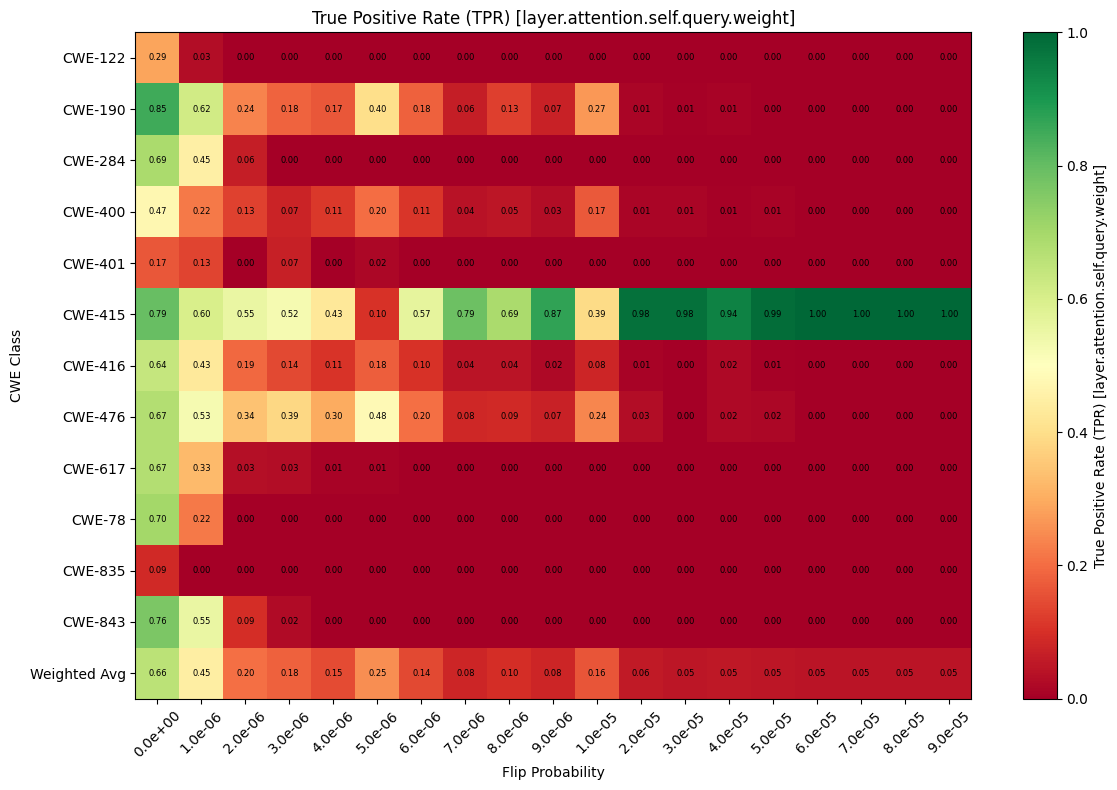

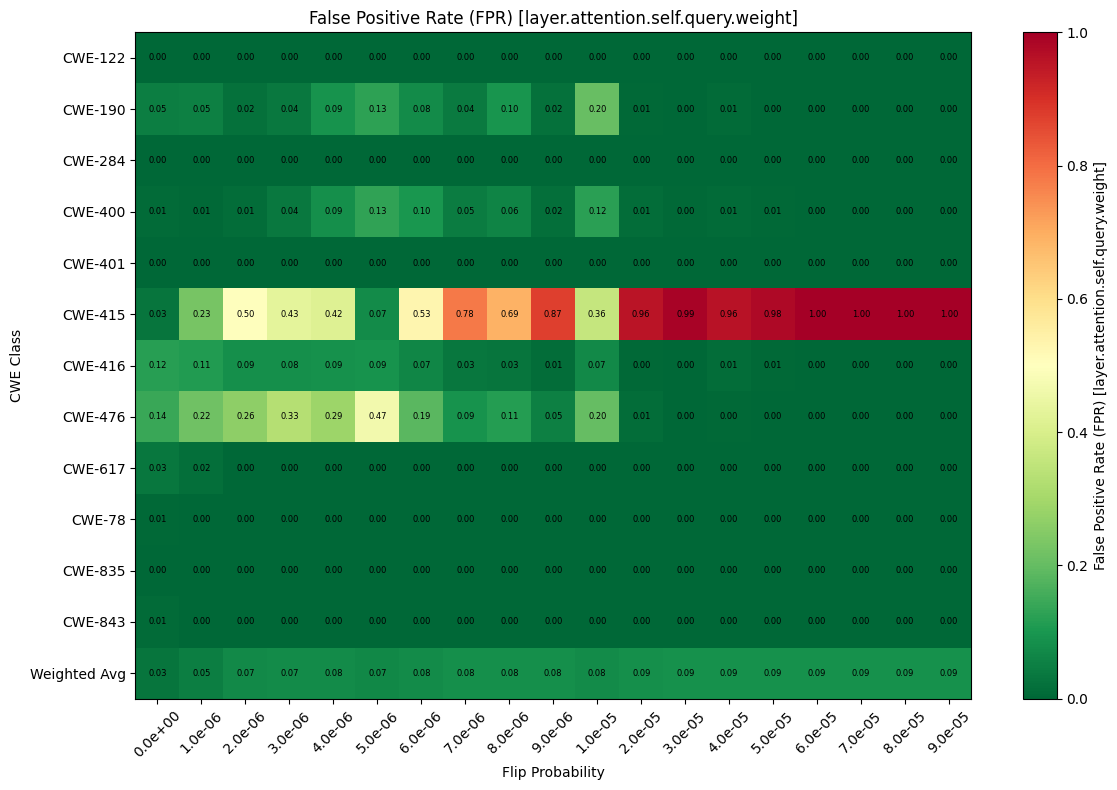

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


base_path = "/content/drive/MyDrive/Colab_Notebooks/MSc_Fault_Tolerance/baseline_model_may"
results_dirs = [
    f"{base_path}/probability_flip_results"
] + [
    f"{base_path}/probability_flip_results_{i}" for i in range(2, 6)
]


records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")  # captures the number after metrics_p and before _run

for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            print(f"Skipping unexpected filename: {file}")
            continue
        flip_prob = float(m.group(1))  # e.g. 2e-06
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        records.append(df[["CWE Class", "TPR", "FPR", "flip_prob"]])

# combine all records and average over experiments
all_df = pd.concat(records, ignore_index=True)
grouped = all_df.groupby(["CWE Class", "flip_prob"], as_index=False).mean()

# Pivot into matrices
tpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="TPR")
fpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="FPR")

tpr_matrix = tpr_matrix.reindex(sorted(tpr_matrix.columns), axis=1)
fpr_matrix = fpr_matrix.reindex(sorted(fpr_matrix.columns), axis=1)

def plot_heatmap(mat, title, cmap, filename):
    plt.figure(figsize=(12, 8))
    im = plt.imshow(mat.values, aspect="auto", cmap=cmap, vmin=0.0, vmax=1.0)
    plt.colorbar(im, label=title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f"{mat.values[i, j]:.2f}",
                     ha="center", va="center", color="black", fontsize=6)
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), [f"{fp:.1e}" for fp in mat.columns], rotation=45)
    plt.xlabel("Flip Probability")
    plt.ylabel("CWE Class")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_heatmap(tpr_matrix, "True Positive Rate (TPR) [layer.attention.self.query.weight]", cmap="RdYlGn", filename="TPR_avg_over_5runs.png")
plot_heatmap(fpr_matrix, "False Positive Rate (FPR) [layer.attention.self.query.weight]", cmap="RdYlGn_r", filename="FPR_avg_over_5runs.png")


# Interesting result with CWE-415. Let's test standard deviation and statistical significance:

| CWE ID   | Train | Test |
|----------|-------|------|
| CWE-122  | 52    | 21   |
| CWE-190  | 508   | 179  |
| CWE-284  | 62    | 16   |
| CWE-400  | 121   | 40   |
| CWE-401  | 60    | 24   |
| CWE-415  | 142   | 29   |
| CWE-416  | 313   | 108  |
| CWE-476  | 361   | 110  |
| CWE-617  | 99    | 43   |
| CWE-78   | 50    | 10   |
| CWE-835  | 47    | 23   |
| CWE-843  | 43    | 17   |


CWE-415 has 142 train subjects and 29 test subjects.

Let's plot the TPR distribution over an increasing probability of bit flip injections for CWE-415

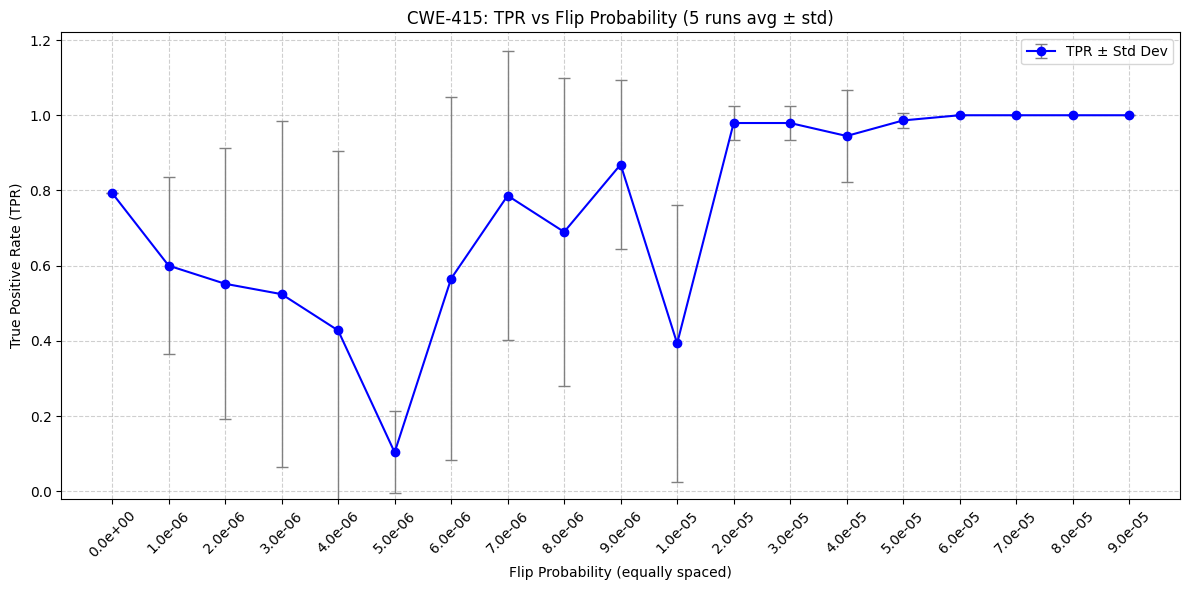

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setup paths and pattern
base_path = "/content/drive/MyDrive/Colab_Notebooks/MSc_Fault_Tolerance/baseline_model_may"
results_dirs = [
    f"{base_path}/probability_flip_results"
] + [
    f"{base_path}/probability_flip_results_{i}" for i in range(2, 6)
]

records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")

# Load and filter for CWE-415
for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            continue
        flip_prob = float(m.group(1))
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        df = df[df["CWE Class"] == "CWE-415"]
        records.append(df[["TPR", "flip_prob"]])

#  Concatenate and compute mean + std
df_415 = pd.concat(records, ignore_index=True)
summary = df_415.groupby("flip_prob").agg(
    mean_tpr=("TPR", "mean"),
    std_tpr=("TPR", "std")
).reset_index()

x_vals = range(len(summary))  # Treat as categorical axis
x_labels = [f"{fp:.1e}" for fp in summary["flip_prob"]]

plt.figure(figsize=(12, 6))
plt.errorbar(
    x_vals,
    summary["mean_tpr"],
    yerr=summary["std_tpr"],
    fmt='-o',
    capsize=4,
    color='blue',
    ecolor='gray',
    elinewidth=1,
    label="TPR ± Std Dev"
)
plt.xticks(x_vals, x_labels, rotation=45)

plt.xlabel("Flip Probability (equally spaced)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("CWE-415: TPR vs Flip Probability (5 runs avg ± std)")
y_max = (summary["mean_tpr"] + summary["std_tpr"]).max()

# Calculate upper and lower bounds for y-axis
lower_bound = max(0, (summary["mean_tpr"] - summary["std_tpr"]).min())
upper_bound = (summary["mean_tpr"] + summary["std_tpr"]).max()
plt.ylim(lower_bound - 0.02, upper_bound + 0.05)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


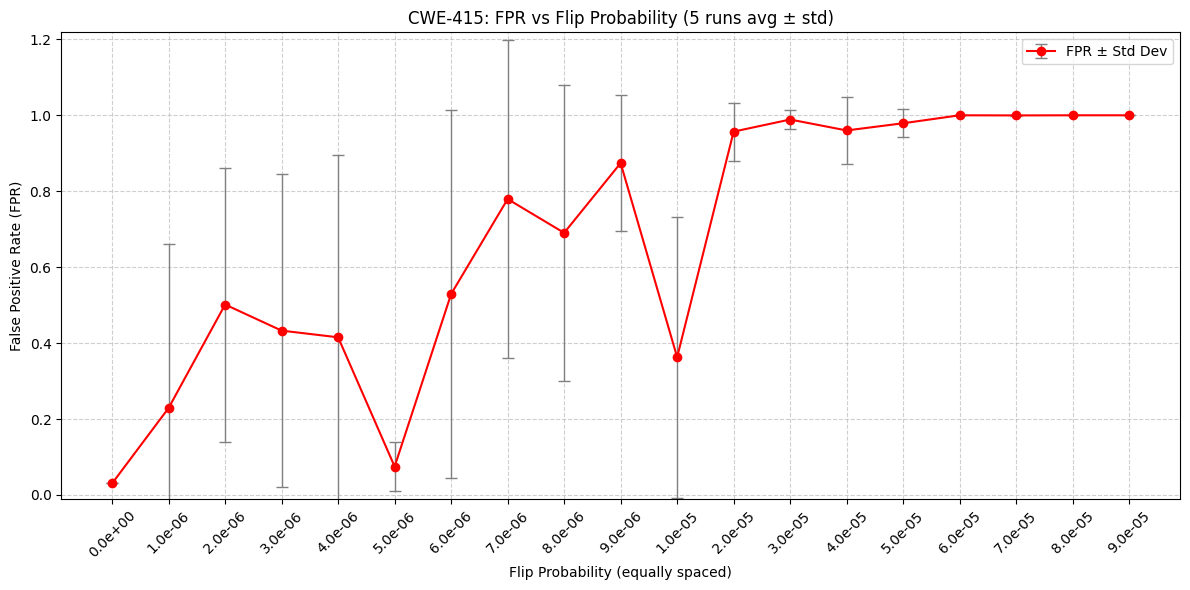

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/Colab_Notebooks/MSc_Fault_Tolerance/baseline_model_may"
results_dirs = [
    f"{base_path}/probability_flip_results"
] + [
    f"{base_path}/probability_flip_results_{i}" for i in range(2, 6)
]

records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")

for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            continue
        flip_prob = float(m.group(1))
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        df = df[df["CWE Class"] == "CWE-415"]
        records.append(df[["FPR", "flip_prob"]])

df_415 = pd.concat(records, ignore_index=True)
summary = df_415.groupby("flip_prob").agg(
    mean_fpr=("FPR", "mean"),
    std_fpr=("FPR", "std")
).reset_index()

x_vals = range(len(summary))  # Treat as categorical axis
x_labels = [f"{fp:.1e}" for fp in summary["flip_prob"]]

plt.figure(figsize=(12, 6))
plt.errorbar(
    x_vals,
    summary["mean_fpr"],
    yerr=summary["std_fpr"],
    fmt='-o',
    capsize=4,
    color='red',         # Red line for FPR
    ecolor='gray',
    elinewidth=1,
    label="FPR ± Std Dev"
)
plt.xticks(x_vals, x_labels, rotation=45)

plt.xlabel("Flip Probability (equally spaced)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("CWE-415: FPR vs Flip Probability (5 runs avg ± std)")

lower_bound = max(0, (summary["mean_fpr"] - summary["std_fpr"]).min())
upper_bound = (summary["mean_fpr"] + summary["std_fpr"]).max()
plt.ylim(lower_bound - 0.01, upper_bound + 0.02)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# It's worth also analysing the rest of weight types in the attention block:

| Weight Matrix     | # Params | % of `layer.attention` |
| ----------------- | -------- | ---------------------- |
| `query.weight`    | 589,824  | 25%                    |
| `key.weight`      | 589,824  | 25%                    |
| `value.weight`    | 589,824  | 25%                    |
| `out_proj.weight` | 589,824  | 25%                    |



## Now bit-flipping attention.self.key.weight:

### Confusion Matrix for True Positive Rate and False Positive Rate

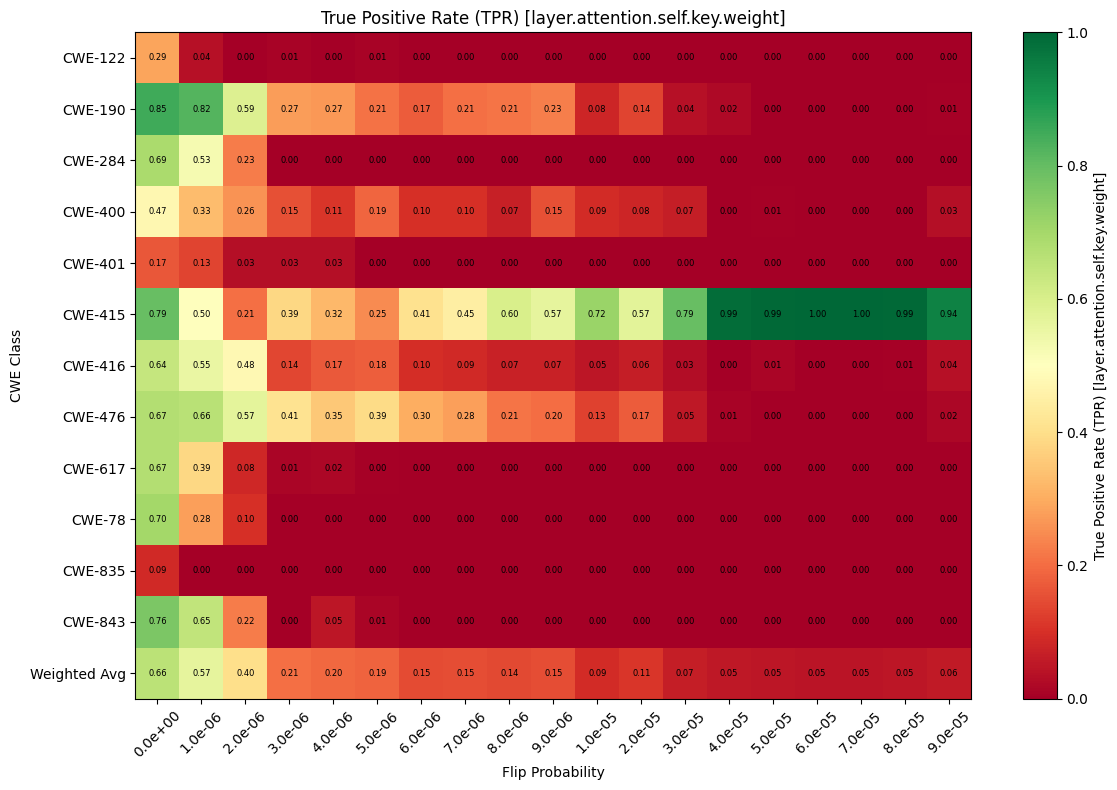

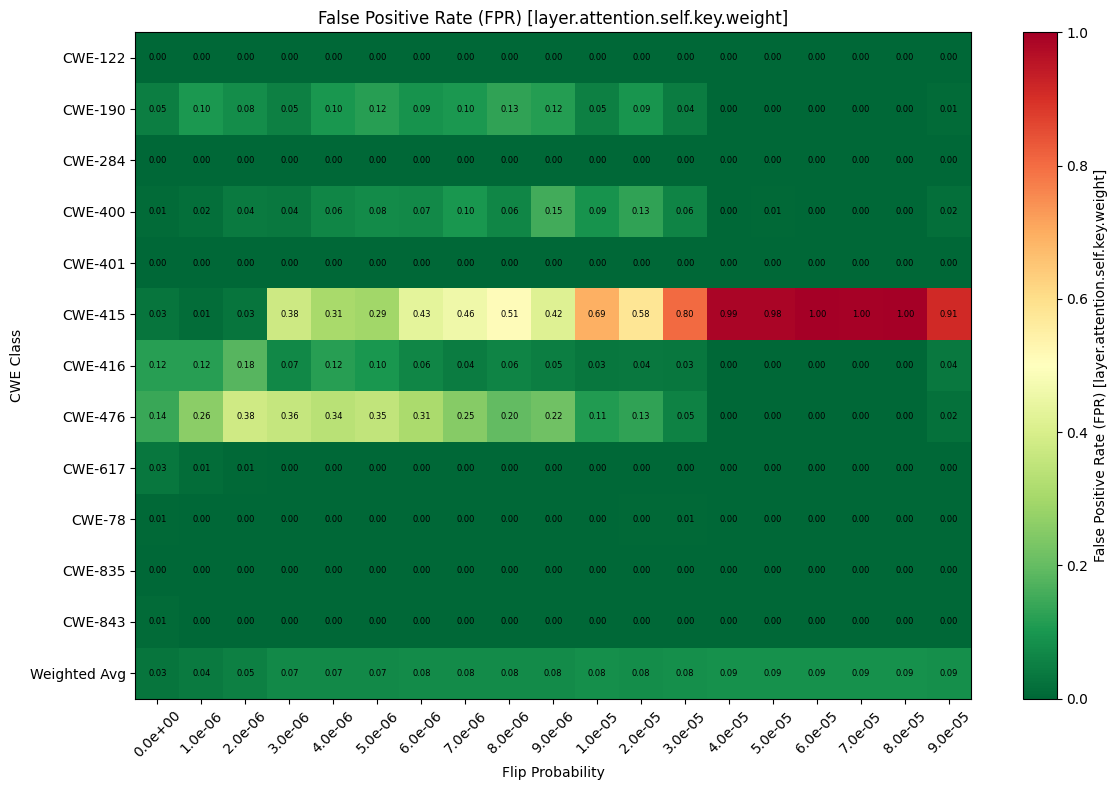

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


results_dirs = [
    f"{base_path}/probability_flip_results_key1"
] + [
    f"{base_path}/probability_flip_results_key{i}" for i in range(2, 6)
]



records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")  # captures the number after metrics_p and before _run

for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            print(f"Skipping unexpected filename: {file}")
            continue
        flip_prob = float(m.group(1))  # e.g. 2e-06
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        records.append(df[["CWE Class", "TPR", "FPR", "flip_prob"]])

# combine all records and average over experiments
all_df = pd.concat(records, ignore_index=True)
grouped = all_df.groupby(["CWE Class", "flip_prob"], as_index=False).mean()

# Pivot into matrices
tpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="TPR")
fpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="FPR")

tpr_matrix = tpr_matrix.reindex(sorted(tpr_matrix.columns), axis=1)
fpr_matrix = fpr_matrix.reindex(sorted(fpr_matrix.columns), axis=1)

def plot_heatmap(mat, title, cmap, filename):
    plt.figure(figsize=(12, 8))
    im = plt.imshow(mat.values, aspect="auto", cmap=cmap, vmin=0.0, vmax=1.0)
    plt.colorbar(im, label=title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f"{mat.values[i, j]:.2f}",
                     ha="center", va="center", color="black", fontsize=6)
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), [f"{fp:.1e}" for fp in mat.columns], rotation=45)
    plt.xlabel("Flip Probability")
    plt.ylabel("CWE Class")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_heatmap(tpr_matrix, "True Positive Rate (TPR) [layer.attention.self.key.weight]", cmap="RdYlGn", filename="TPR_avg_over_5runs.png")
plot_heatmap(fpr_matrix, "False Positive Rate (FPR) [layer.attention.self.key.weight]", cmap="RdYlGn_r", filename="FPR_avg_over_5runs.png")


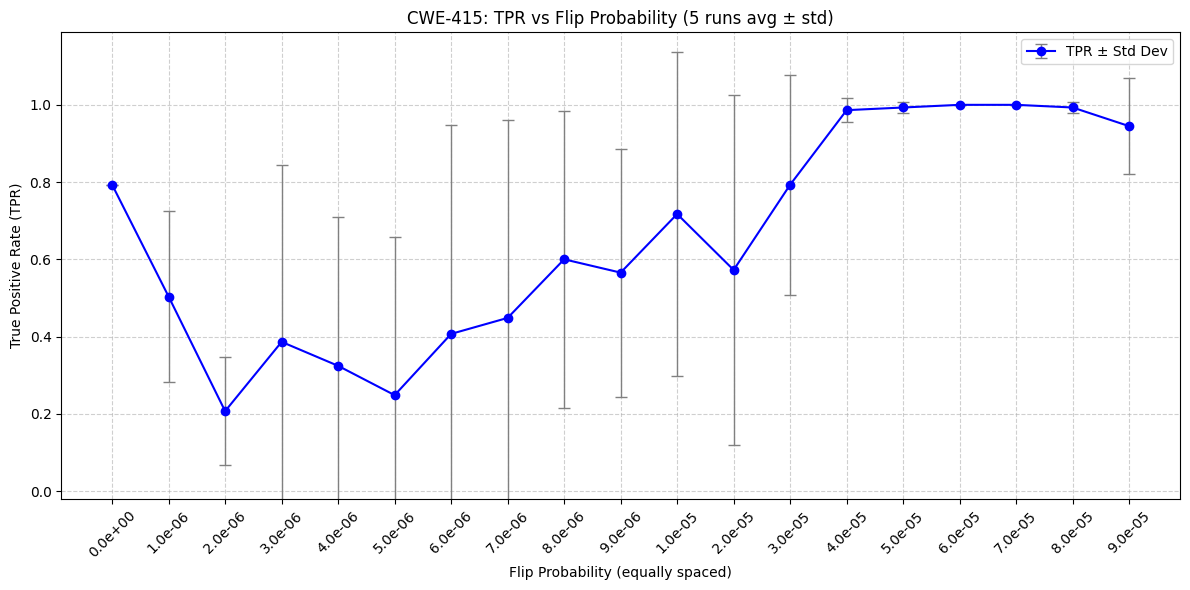

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setup paths and pattern
base_path = "/content/drive/MyDrive/Colab_Notebooks/MSc_Fault_Tolerance/baseline_model_may"
results_dirs = [
    f"{base_path}/probability_flip_results_key1"
] + [
    f"{base_path}/probability_flip_results_key{i}" for i in range(2, 6)
]

records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")

# Load and filter for CWE-415
for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            continue
        flip_prob = float(m.group(1))
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        df = df[df["CWE Class"] == "CWE-415"]
        records.append(df[["TPR", "flip_prob"]])

#  Concatenate and compute mean + std
df_415 = pd.concat(records, ignore_index=True)
summary = df_415.groupby("flip_prob").agg(
    mean_tpr=("TPR", "mean"),
    std_tpr=("TPR", "std")
).reset_index()

x_vals = range(len(summary))  # Treat as categorical axis
x_labels = [f"{fp:.1e}" for fp in summary["flip_prob"]]

plt.figure(figsize=(12, 6))
plt.errorbar(
    x_vals,
    summary["mean_tpr"],
    yerr=summary["std_tpr"],
    fmt='-o',
    capsize=4,
    color='blue',
    ecolor='gray',
    elinewidth=1,
    label="TPR ± Std Dev"
)
plt.xticks(x_vals, x_labels, rotation=45)

plt.xlabel("Flip Probability (equally spaced)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("CWE-415: TPR vs Flip Probability (5 runs avg ± std)")
y_max = (summary["mean_tpr"] + summary["std_tpr"]).max()

# Calculate upper and lower bounds for y-axis
lower_bound = max(0, (summary["mean_tpr"] - summary["std_tpr"]).min())
upper_bound = (summary["mean_tpr"] + summary["std_tpr"]).max()
plt.ylim(lower_bound - 0.02, upper_bound + 0.05)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


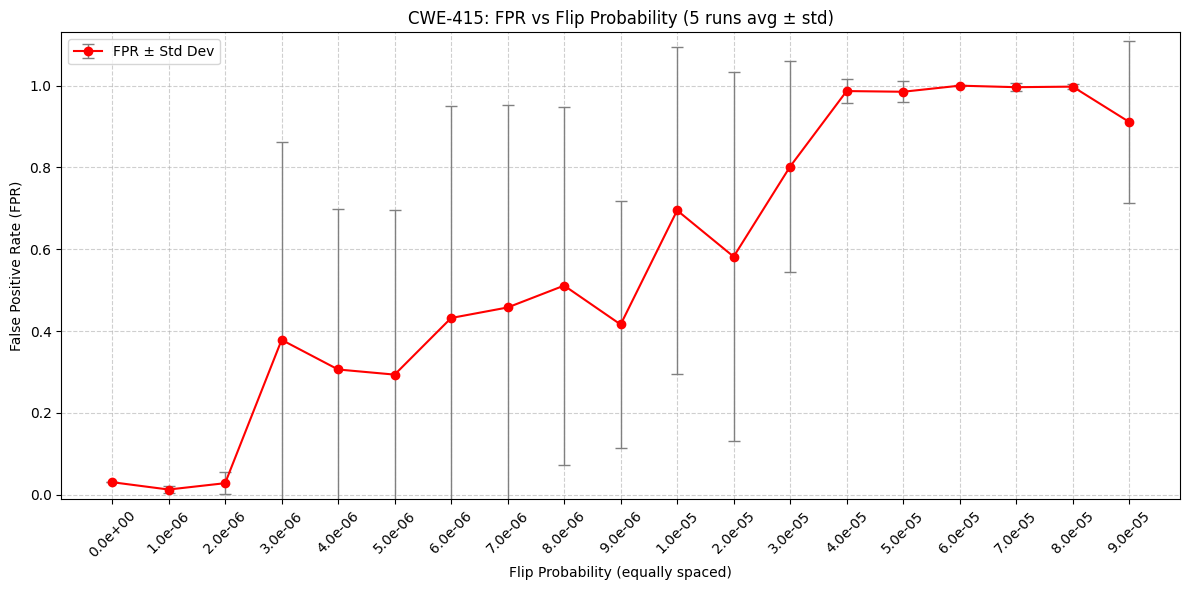

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/Colab_Notebooks/MSc_Fault_Tolerance/baseline_model_may"
results_dirs = [
    f"{base_path}/probability_flip_results_key1"
] + [
    f"{base_path}/probability_flip_results_key{i}" for i in range(2, 6)
]

records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")

for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            continue
        flip_prob = float(m.group(1))
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        df = df[df["CWE Class"] == "CWE-415"]
        records.append(df[["FPR", "flip_prob"]])

df_415 = pd.concat(records, ignore_index=True)
summary = df_415.groupby("flip_prob").agg(
    mean_fpr=("FPR", "mean"),
    std_fpr=("FPR", "std")
).reset_index()

x_vals = range(len(summary))  # Treat as categorical axis
x_labels = [f"{fp:.1e}" for fp in summary["flip_prob"]]

plt.figure(figsize=(12, 6))
plt.errorbar(
    x_vals,
    summary["mean_fpr"],
    yerr=summary["std_fpr"],
    fmt='-o',
    capsize=4,
    color='red',         # Red line for FPR
    ecolor='gray',
    elinewidth=1,
    label="FPR ± Std Dev"
)
plt.xticks(x_vals, x_labels, rotation=45)

plt.xlabel("Flip Probability (equally spaced)")
plt.ylabel("False Positive Rate (FPR)")
plt.title("CWE-415: FPR vs Flip Probability (5 runs avg ± std)")

lower_bound = max(0, (summary["mean_fpr"] - summary["std_fpr"]).min())
upper_bound = (summary["mean_fpr"] + summary["std_fpr"]).max()
plt.ylim(lower_bound - 0.01, upper_bound + 0.02)

plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


#Now bit-flipping attention.self.value.weight:

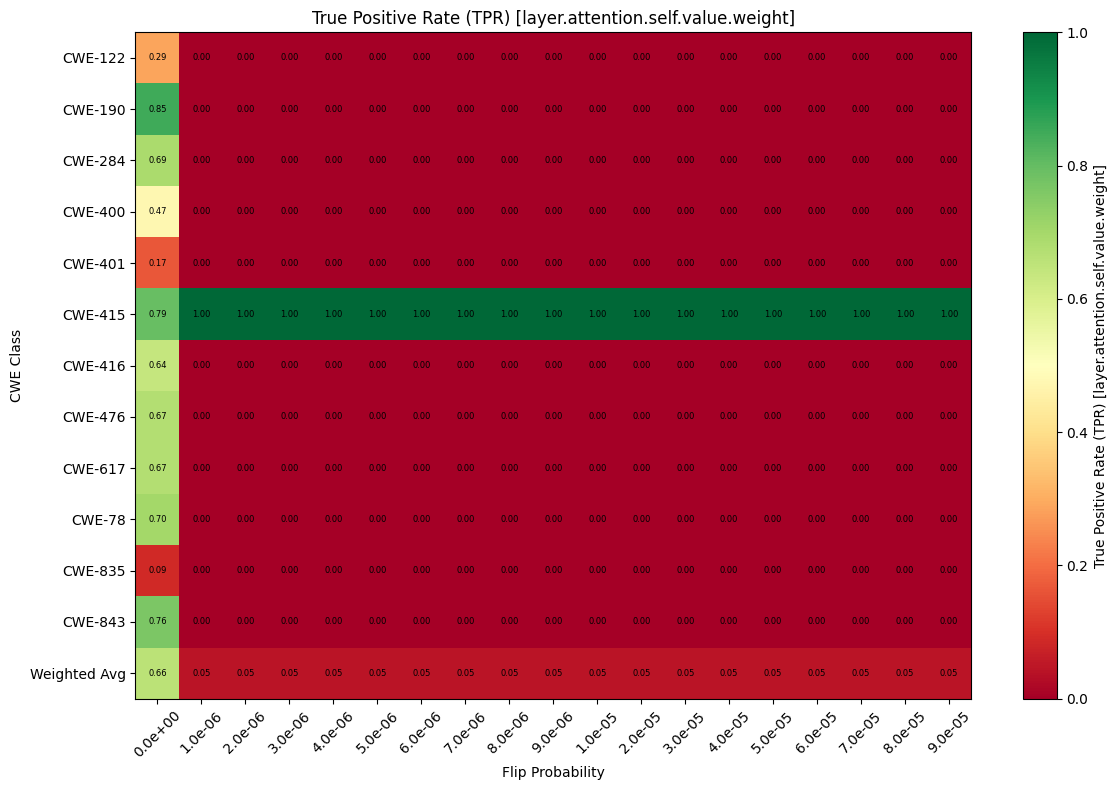

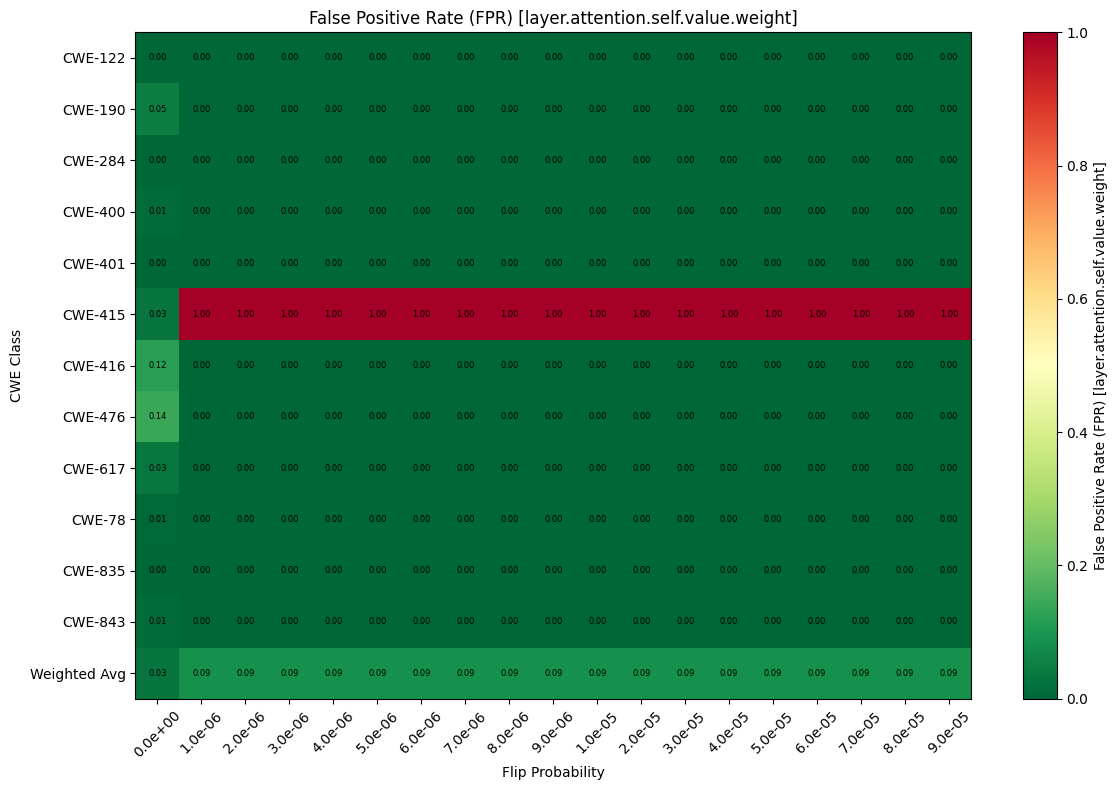

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_path = "/content/drive/MyDrive/Colab_Notebooks/MSc_Fault_Tolerance/baseline_model_may"
results_dirs = [
    f"{base_path}/probability_flip_results_value_1"
] + [
    f"{base_path}/probability_flip_results_value_{i}" for i in range(2, 6)
]



records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")  # captures the number after metrics_p and before _run

for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            print(f"Skipping unexpected filename: {file}")
            continue
        flip_prob = float(m.group(1))  # e.g. 2e-06
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        records.append(df[["CWE Class", "TPR", "FPR", "flip_prob"]])

# combine all records and average over experiments
all_df = pd.concat(records, ignore_index=True)
grouped = all_df.groupby(["CWE Class", "flip_prob"], as_index=False).mean()

# Pivot into matrices
tpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="TPR")
fpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="FPR")

tpr_matrix = tpr_matrix.reindex(sorted(tpr_matrix.columns), axis=1)
fpr_matrix = fpr_matrix.reindex(sorted(fpr_matrix.columns), axis=1)

def plot_heatmap(mat, title, cmap, filename):
    plt.figure(figsize=(12, 8))
    im = plt.imshow(mat.values, aspect="auto", cmap=cmap, vmin=0.0, vmax=1.0)
    plt.colorbar(im, label=title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f"{mat.values[i, j]:.2f}",
                     ha="center", va="center", color="black", fontsize=6)
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), [f"{fp:.1e}" for fp in mat.columns], rotation=45)
    plt.xlabel("Flip Probability")
    plt.ylabel("CWE Class")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_heatmap(tpr_matrix, "True Positive Rate (TPR) [layer.attention.self.value.weight]", cmap="RdYlGn", filename="TPR_avg_over_5runs.png")
plot_heatmap(fpr_matrix, "False Positive Rate (FPR) [layer.attention.self.value.weight]", cmap="RdYlGn_r", filename="FPR_avg_over_5runs.png")


Now bit-flipping attention.self.out_proj.weight:

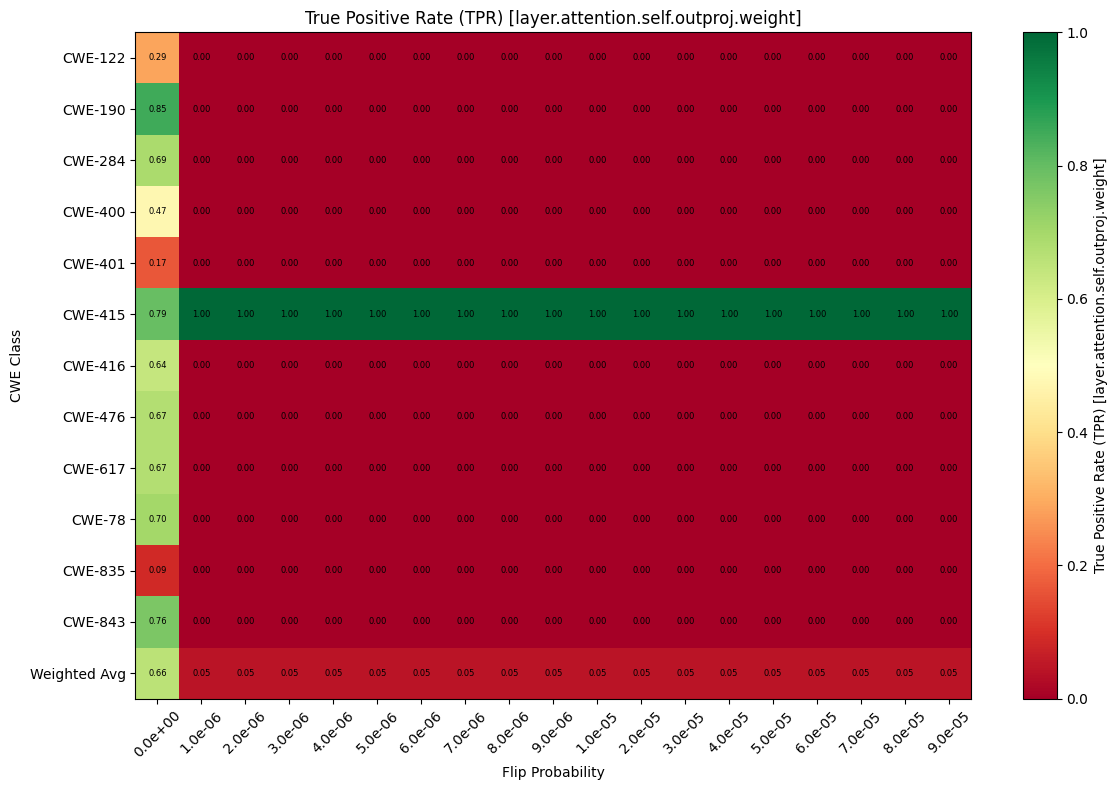

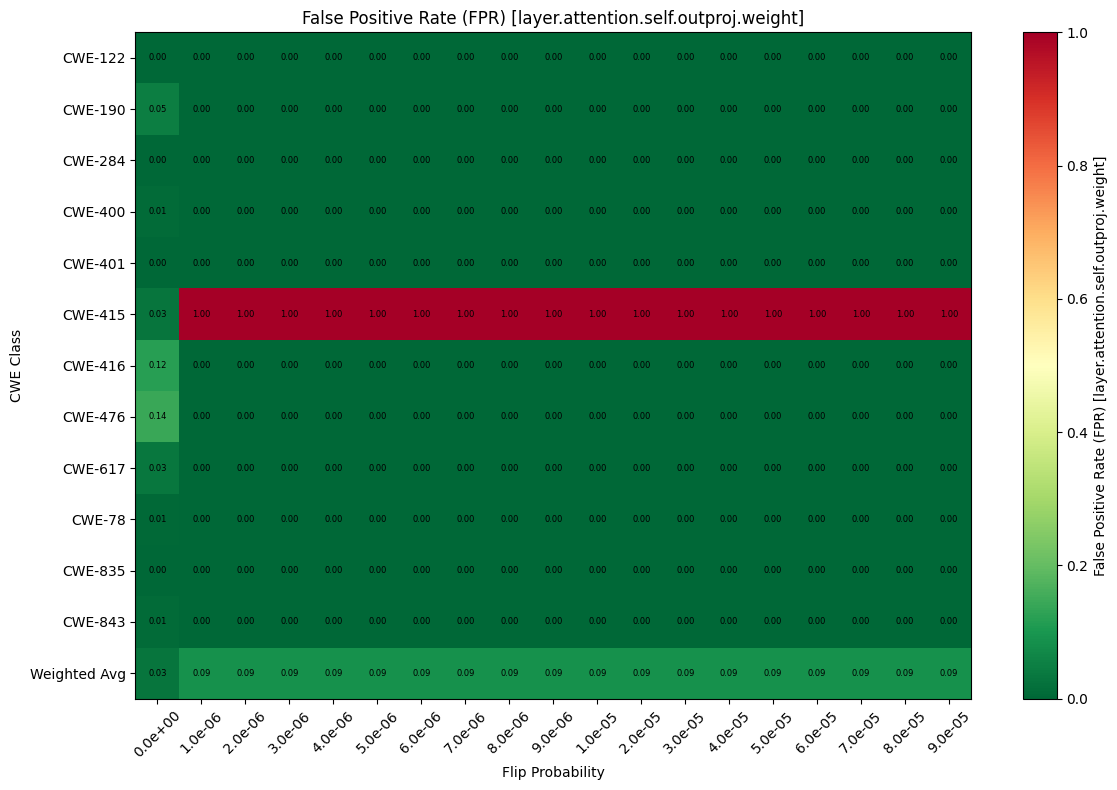

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


results_dirs = [
    f"{base_path}/probability_flip_results_outproj_1"
] + [
    f"{base_path}/probability_flip_results_outproj_{i}" for i in range(2, 6)
]



records = []
pattern = re.compile(r"metrics_p([0-9\.eE+-]+)_run")  # captures the number after metrics_p and before _run

for results_dir in results_dirs:
    files = [f for f in os.listdir(results_dir) if f.startswith("metrics_p") and f.endswith(".csv")]
    for file in files:
        m = pattern.search(file)
        if not m:
            print(f"Skipping unexpected filename: {file}")
            continue
        flip_prob = float(m.group(1))  # e.g. 2e-06
        df = pd.read_csv(os.path.join(results_dir, file))
        df["flip_prob"] = flip_prob
        records.append(df[["CWE Class", "TPR", "FPR", "flip_prob"]])

# combine all records and average over experiments
all_df = pd.concat(records, ignore_index=True)
grouped = all_df.groupby(["CWE Class", "flip_prob"], as_index=False).mean()

# Pivot into matrices
tpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="TPR")
fpr_matrix = grouped.pivot(index="CWE Class", columns="flip_prob", values="FPR")

tpr_matrix = tpr_matrix.reindex(sorted(tpr_matrix.columns), axis=1)
fpr_matrix = fpr_matrix.reindex(sorted(fpr_matrix.columns), axis=1)

def plot_heatmap(mat, title, cmap, filename):
    plt.figure(figsize=(12, 8))
    im = plt.imshow(mat.values, aspect="auto", cmap=cmap, vmin=0.0, vmax=1.0)
    plt.colorbar(im, label=title)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            plt.text(j, i, f"{mat.values[i, j]:.2f}",
                     ha="center", va="center", color="black", fontsize=6)
    plt.yticks(range(mat.shape[0]), mat.index)
    plt.xticks(range(mat.shape[1]), [f"{fp:.1e}" for fp in mat.columns], rotation=45)
    plt.xlabel("Flip Probability")
    plt.ylabel("CWE Class")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_heatmap(tpr_matrix, "True Positive Rate (TPR) [layer.attention.self.outproj.weight]", cmap="RdYlGn", filename="TPR_avg_over_5runs.png")
plot_heatmap(fpr_matrix, "False Positive Rate (FPR) [layer.attention.self.outproj.weight]", cmap="RdYlGn_r", filename="FPR_avg_over_5runs.png")
